In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
%matplotlib inline

pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

In [23]:
df = pd.read_csv('../US_births.csv', low_memory=False)
df = df.sample(n=250_000, random_state=42)
df.shape

(250000, 55)

In [24]:
def drop_rows(df):
    df.drop(df[df['DBWT'].eq(9999)].index, inplace=True)
#     df['DBWT'] = np.where(df['DBWT'].eq(9999), df[df['DBWT'].lt(9999)]['DBWT'].mean(), df['DBWT'])
    
    df.drop(df[df['BMI'].eq(99.9)].index, inplace=True)
    df.drop(df[df['DBWT'].eq(9999)].index, inplace=True)
    df.drop(df[df['WTGAIN'].eq(99)].index, inplace=True)
    df.drop(df[df['PWgt_R'].eq(999)].index, inplace=True)
#     df.drop(df[df['FAGECOMB'].eq(99)].index, inplace=True)
    df.drop(df[df['DLMP_MM'].eq(99)].index, inplace=True)
    df.drop(df[df['DLMP_YY'].eq(9999)].index, inplace=True)
    return df


In [25]:
df = drop_rows(df)
df.shape

(231493, 55)

In [26]:
def feature_engineer(df):
    df['binary_sex'] = np.where(df['SEX'] == 'M', 1, 0)
    df['first_birth'] = np.where(df['ILLB_R'].eq(888), 1, 0)

    df['binary_sex'] = np.where(df['SEX'] == 'M', 1, 0)
    df['first_birth'] = np.where(df['ILLB_R'].eq(888), 1, 0)

    
    conditions = [df['CIG_0'].eq(0),
                  df['CIG_0'].eq(99)]
    choices = ['None',
               'Unknown']
    df['smoked'] = np.select(conditions, choices, 'Daily')

    
    conditions = [df['PRIORDEAD'].eq(0),
                  df['PRIORDEAD'].eq(99)]
    choices = ['None',
               'Unknown']
    df['PRIORDEAD_cat'] = np.select(conditions, choices, 'Yes')

    
    conditions = [df['PRIORTERM'].eq(0),
                  df['PRIORTERM'].eq(99)]
    choices = ['None',
               'Unknown']
    df['PRIORTERM_cat'] = np.select(conditions, choices, 'Yes')

    
    conditions = [df['PRIORLIVE'].eq(0),
                  df['PRIORLIVE'].eq(99)]
    choices = ['None',
               'Unknown']
    df['PRIORLIVE_cat'] = np.select(conditions, choices, 'Yes')

    
    conditions = [(df['DOB_MM'] > df['DLMP_MM']) & (2018 == df['DLMP_YY']),
                  (df['DOB_MM'] > df['DLMP_MM']) & (2018 > df['DLMP_YY']),
                  (df['DOB_MM'] < df['DLMP_MM']) & (2018 > df['DLMP_YY'])]
    choices = [df['DOB_MM'] - df['DLMP_MM'],
               ((df['DOB_YY'] - df['DLMP_YY'])* 12) + df['DOB_MM'] - df['DLMP_MM'],
               ((df['DOB_YY'] - df['DLMP_YY'])* 12) - df['DLMP_MM'] + df['DOB_MM']]
    df['pregnancy_length'] = np.select(conditions,choices, 12)


    df['MAGER_cat'] = np.where(df['MAGER'].lt(18),'Minor','Adult')

    
    condition =[df['pregnancy_length'].eq(9),
                df['pregnancy_length'].eq(8),
                df['pregnancy_length'].eq(10),
                df['pregnancy_length'].lt(7)]
    choices = ['9',
              '8',
               '10',
               'Early']
    df['pregnancy_length_cat'] = np.select(condition,choices, 'Late')

    
    df['BMI_log'] = np.log(df['BMI'])
    df['first_birth'] = np.where(df['ILLB_R'].eq(888), 1, 0)
    df['plural_delivery'] = np.where(df['ILLB_R'].lt(4), 'Yes', 'No')
    df['first_pregnancy'] = np.where(df['ILP_R'].eq(888), 1, 0)
    df['first_natal'] = np.where(df['ILOP_R'].eq(888),1, 0)
    df['PRECARE'] = np.where(df['PRECARE'].eq(99), 0, df['PRECARE'])
    df['PREVIS'] = np.where(df['PREVIS'].eq(99), 0, df['PREVIS'])
    df['T35AGE_older'] = np.where(df['MAGER'].gt(34), 1, 0)

    df['pregnancy_length_WTGAIN'] = df['pregnancy_length']/df['PWgt_R']
    df['MOM_weight'] = (df['M_Ht_In']**2)*df['BMI']/704
    df['WTGAIN_div_MOM_weight'] = df['WTGAIN']/df['MOM_weight']
    df['WTGAIN_div_length'] = df['WTGAIN'] / df['pregnancy_length']
    df['Weight_before'] = df['MOM_weight'] - df['WTGAIN']
    df['WT_percent_gain'] = df['WTGAIN'] / df['PWgt_R']
    df['MAR_IMP'] = np.where(df['MAR_IMP'].eq(' '),0,1)
    df['DMAR'] = np.where(df['DMAR'].eq(' '),0,df['DMAR'])
    return df


In [27]:
df = feature_engineer(df)
df.shape

(231493, 75)

In [28]:
df['smoked'].value_counts()

None       211962
Daily       18714
Unknown       817
Name: smoked, dtype: int64

In [29]:
X = df[['ATTEND','BFACIL', 'smoked', 'DOB_MM', 'DMAR','FHISPX','FEDUC', 'FRACE6', 'first_birth', 'plural_delivery', 'first_pregnancy', 'first_natal',
        'IP_GON', 'LD_INDL', 'MAGER', 'T35AGE_older','MAR_IMP', 'MBSTATE_REC', 'MEDUC', 'MHISPX', 'MRAVE6', 'MTRAN', 'pregnancy_length', 'WTGAIN_div_MOM_weight','WTGAIN_div_length',
        'NO_INFEC','NO_MMORB','NO_RISKS','PAY', 'PAY_REC','PRECARE','PREVIS', 'PRIORDEAD_cat', 'PRIORLIVE_cat', 'PRIORTERM_cat', 'PWgt_R', 'BMI_log','M_Ht_In', 'MOM_weight',
        'RDMETH_REC', 'RESTATUS', 'RF_CESAR', 'SEX', 'WTGAIN','WT_percent_gain','MAGER_cat','pregnancy_length_cat','BMI'
]]
_X = pd.get_dummies(X, columns=['ATTEND', 'BFACIL','smoked', 'DOB_MM','DMAR','FHISPX','FEDUC','FRACE6', 'plural_delivery',
                                'IP_GON','LD_INDL', 'T35AGE_older','MAR_IMP', 'MBSTATE_REC', 'MEDUC', 'MHISPX', 'MRAVE6', 'MTRAN',
                                'NO_INFEC','NO_MMORB','NO_RISKS', 'PAY', 'PAY_REC','PRIORDEAD_cat', 'PRIORLIVE_cat','PRIORTERM_cat',
                                'RDMETH_REC', 'RESTATUS', 'RF_CESAR', 'SEX','MAGER_cat','pregnancy_length_cat'])
y = df['DBWT']

In [30]:
def feat_eng_dummy(_X):
    _X['MAGER_smoked_Daily'] = _X['MAGER'] * _X['smoked_Daily']
    _X['NO_RISKS_1_length'] = _X['NO_RISKS_1'] * _X['pregnancy_length']
    _X['RDMETH_REC_3_length'] = _X['RDMETH_REC_3'] * _X['pregnancy_length']
    _X['RDMETH_REC_1_length'] = _X['RDMETH_REC_1'] * _X['pregnancy_length']
    _X['ATTEND_1_length'] = _X['pregnancy_length'] * _X['ATTEND_1']
    _X['MRAVE6_1_FRACE6_1'] = _X['MRAVE6_1'] * _X['FRACE6_1']
    _X['BFACIL_1_length'] = _X['pregnancy_length'] * _X['BFACIL_1']
    _X['BMI_log_length'] = _X['BMI_log'] * _X['pregnancy_length']
    _X['M_Ht_In_length'] = _X['DMAR_1'] * _X['pregnancy_length']
    _X['LD_INDL_N_length'] = _X['LD_INDL_N'] * _X['pregnancy_length']
    _X['MTRAN_Y_length'] = _X['MTRAN_Y'] * _X['pregnancy_length']
    _X['PRECARE_length'] = _X['PRECARE'] * _X['pregnancy_length']
    _X['PREVIS_length'] = _X['PREVIS'] * _X['pregnancy_length']
    _X['MOM_weight_length'] = _X['MOM_weight'] * _X['pregnancy_length']

    _X['RDMETH_REC_3_pregnancy_length_cat_9'] = _X['RDMETH_REC_3'] * _X['pregnancy_length_cat_9']
    _X['RF_CESAR_Y_pregnancy_length_cat_9'] = _X['RF_CESAR_Y'] * _X['pregnancy_length_cat_9']
    return _X

In [31]:
_X = feat_eng_dummy(_X)
_X.shape

(231493, 183)

In [32]:
_X['DBWT'] = df['DBWT']

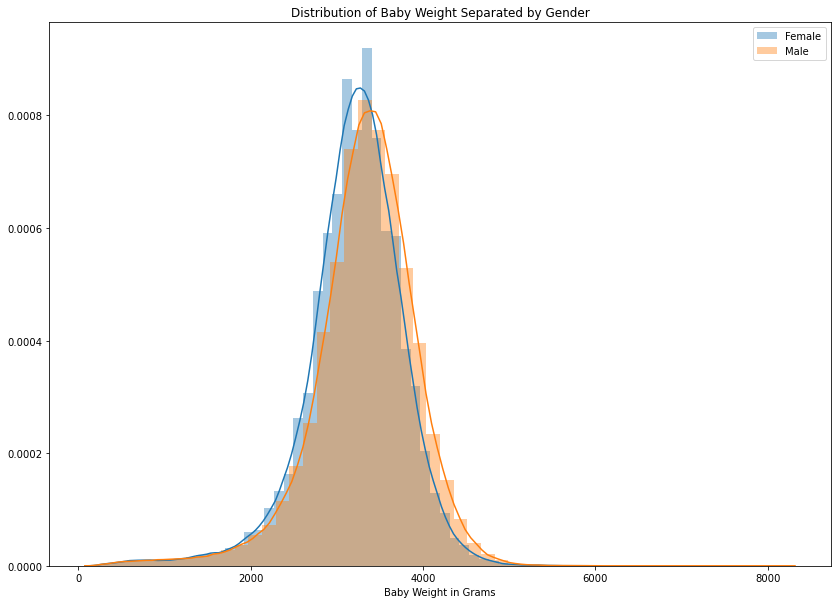

In [33]:
plt.figure(figsize=(14,10))
sns.distplot(_X[_X['SEX_M'].eq(0)]['DBWT'], label = 'Female')
sns.distplot(_X[_X['SEX_M'].eq(1)]['DBWT'], label = 'Male')
plt.title('Distribution of Baby Weight Separated by Gender')
plt.xlabel('Baby Weight in Grams')
plt.legend();

In [34]:
# null: Male Baby Weight = Female Baby Weight
# alt: Male Baby Weight != Female Baby Weight
# alpha: 0.05
stats.f_oneway(_X[_X['SEX_M'].eq(0)]['DBWT'],
              _X[_X['SEX_M'].eq(1)]['DBWT'])

F_onewayResult(statistic=2332.4651880432652, pvalue=0.0)

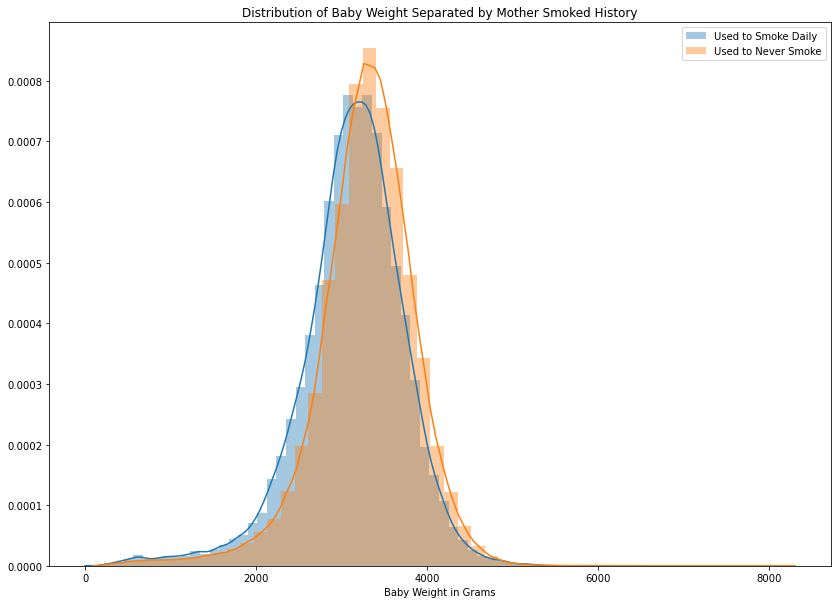

In [35]:
plt.figure(figsize=(14,10))
sns.distplot(_X[_X['smoked_Daily'].eq(1)]['DBWT'], label = 'Used to Smoke Daily')
sns.distplot(_X[_X['smoked_None'].eq(1)]['DBWT'], label = 'Used to Never Smoke')
plt.title('Distribution of Baby Weight Separated by Mother Smoked History')
plt.xlabel('Baby Weight in Grams')
plt.legend();

In [36]:
# null: Baby Weight of Moms who used to Smoke Daily = Baby Weight of Moms who never smoked
# alt: Baby Weight of Moms who used to Smoke Daily != Baby Weight of Moms who never smoked
# alpha: 0.05
stats.f_oneway(_X[_X['smoked_Daily'].eq(1)]['DBWT'],
              _X[_X['smoked_None'].eq(1)]['DBWT'])

F_onewayResult(statistic=1299.7304498814483, pvalue=8.038285484194107e-284)

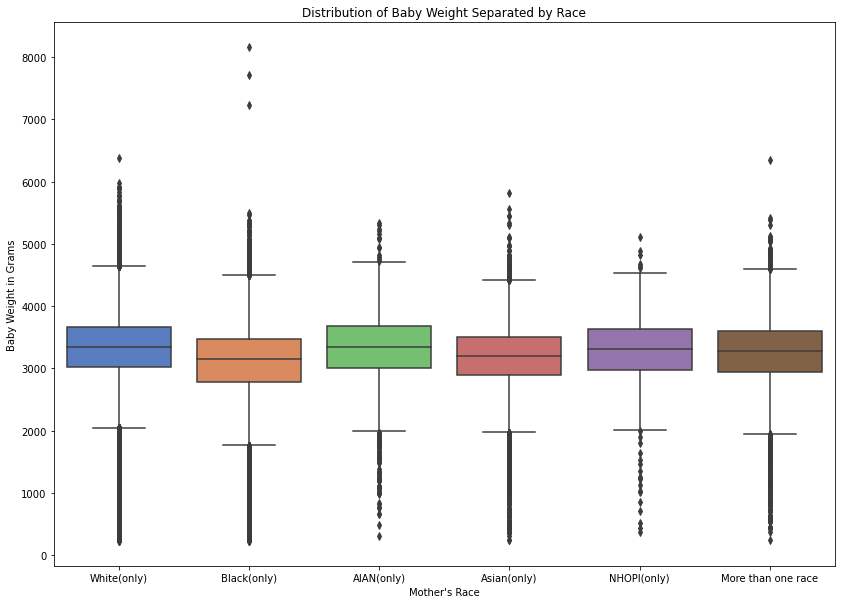

In [37]:
fig, ax = plt.subplots(figsize=(14,10))
sns.boxplot(x='MRAVE6',y='DBWT', data=df, palette='muted')
ax.set_title('Distribution of Baby Weight Separated by Race')
ax.set_xlabel('Mother\'s Race')
ax.set_ylabel('Baby Weight in Grams')
ax.set_xticklabels(['White(only)','Black(only)','AIAN(only)','Asian(only)','NHOPI(only)','More than one race']);

In [38]:
# null: Baby Weights of Moms of different Race are equal
# alt: Baby Weights of Moms of different Race are NOT equal
# alpha: 0.05
stats.f_oneway(_X[_X['MRAVE6_1'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_2'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_3'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_4'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_5'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_6'].eq(1)]['DBWT'])

F_onewayResult(statistic=1066.685036978029, pvalue=0.0)

In [39]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
_result = pairwise_tukeyhsd(df['DBWT'],df['MRAVE6'])
_result._results_table

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-232.5056,0.001,-242.0421,-222.969,True
1,3,-3.3859,0.9,-38.5114,31.7396,False
1,4,-143.9803,0.001,-157.68,-130.2806,True
1,5,-30.3488,0.7022,-92.2638,31.5662,False
1,6,-81.9965,0.001,-103.4004,-60.5926,True
2,3,229.1197,0.001,193.1593,265.0801,True
2,4,88.5253,0.001,72.808,104.2426,True
2,5,202.1568,0.001,139.7643,264.5492,True
2,6,150.509,0.001,127.7609,173.2572,True
3,4,-140.5944,0.001,-177.8755,-103.3132,True


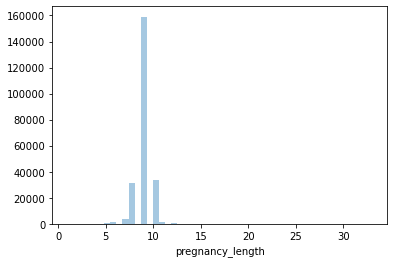

In [40]:
sns.distplot(df['pregnancy_length'],kde=False)

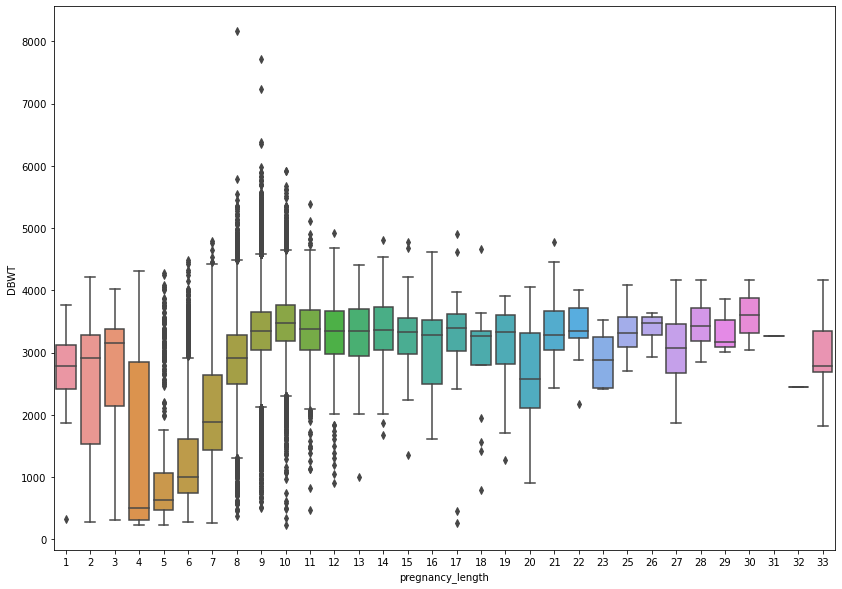

In [41]:
plt.figure(figsize=(14,10))
sns.boxplot(x='pregnancy_length',y='DBWT',data=df)

Text(0, 0.5, 'Baby Weight by Grams')

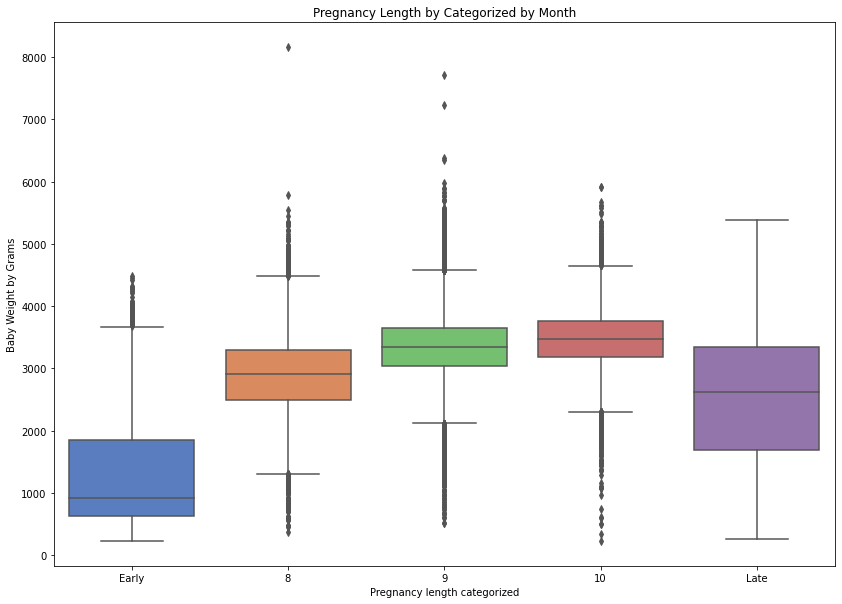

In [52]:
plt.figure(figsize=(14,10))
sns.boxplot(x='pregnancy_length_cat',y='DBWT',data=df, order=['Early','8','9','10','Late'], palette = 'muted')
plt.title('Pregnancy Length by Categorized by Month')
plt.xlabel('Pregnancy length categorized')
plt.ylabel('Baby Weight by Grams')

In [54]:
# null: Baby Weights of Moms of different Race are equal
# alt: Baby Weights of Moms of different Race are NOT equal
# alpha: 0.05
stats.f_oneway(df[df['pregnancy_length_cat'].eq('Early')]['DBWT'],
              df[df['pregnancy_length_cat'].eq('8')]['DBWT'],
              df[df['pregnancy_length_cat'].eq('9')]['DBWT'],
              df[df['pregnancy_length_cat'].eq('10')]['DBWT'],
              df[df['pregnancy_length_cat'].eq('Late')]['DBWT'])

F_onewayResult(statistic=16005.670136125382, pvalue=0.0)

In [55]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
_result = pairwise_tukeyhsd(df['DBWT'],df['pregnancy_length_cat'])
_result._results_table

group1,group2,meandiff,p-adj,lower,upper,reject
10,8,-592.8846,0.001,-603.9656,-581.8036,True
10,9,-131.6751,0.001,-140.1378,-123.2124,True
10,Early,-2111.6606,0.001,-2145.1885,-2078.1327,True
10,Late,-951.0594,0.001,-970.7679,-931.3509,True
8,9,461.2095,0.001,452.4856,469.9335,True
8,Early,-1518.776,0.001,-1552.3708,-1485.1812,True
8,Late,-358.1748,0.001,-377.9968,-338.3527,True
9,Early,-1979.9855,0.001,-2012.8099,-1947.1612,True
9,Late,-819.3843,0.001,-837.8706,-800.898,True
Early,Late,1160.6012,0.001,1123.2616,1197.9408,True


In [13]:
_X.shape

(3521224, 183)

In [14]:
_X['pregnancy_length_sqrt'] =  np.sqrt(_X['pregnancy_length'])
_X_columns = _X.columns

In [15]:
_X.describe()

,first_birth,first_pregnancy,first_natal,MAGER,pregnancy_length,WTGAIN_div_MOM_weight,WTGAIN_div_length,PRECARE,PREVIS,PWgt_R,BMI_log,M_Ht_In,MOM_weight,WTGAIN,WT_percent_gain,BMI,ATTEND_1,ATTEND_2,ATTEND_3,ATTEND_4,ATTEND_5,ATTEND_9,BFACIL_1,BFACIL_2,BFACIL_3,BFACIL_4,BFACIL_5,BFACIL_6,BFACIL_7,BFACIL_9,smoked_Daily,smoked_None,smoked_Unknown,DOB_MM_1,DOB_MM_2,DOB_MM_3,DOB_MM_4,DOB_MM_5,DOB_MM_6,DOB_MM_7,DOB_MM_8,DOB_MM_9,DOB_MM_10,DOB_MM_11,DOB_MM_12,DMAR_0,DMAR_1,DMAR_2,FHISPX_0,FHISPX_1,FHISPX_2,FHISPX_3,FHISPX_4,FHISPX_5,FHISPX_6,FHISPX_9,FEDUC_1,FEDUC_2,FEDUC_3,FEDUC_4,FEDUC_5,FEDUC_6,FEDUC_7,FEDUC_8,FEDUC_9,FRACE6_1,FRACE6_2,FRACE6_3,FRACE6_4,FRACE6_5,FRACE6_6,FRACE6_9,plural_delivery_No,plural_delivery_Yes,IP_GON_N,IP_GON_U,IP_GON_Y,LD_INDL_N,LD_INDL_U,LD_INDL_Y,T35AGE_older_0,T35AGE_older_1,MAR_IMP_0,MAR_IMP_1,MBSTATE_REC_1,MBSTATE_REC_2,MBSTATE_REC_3,MEDUC_1,MEDUC_2,MEDUC_3,MEDUC_4,MEDUC_5,MEDUC_6,MEDUC_7,MEDUC_8,MEDUC_9,MHISPX_0,MHISPX_1,MHISPX_2,MHISPX_3,MHISPX_4,MHISPX_5,MHISPX_6,MHISPX_9,MRAVE6_1,MRAVE6_2,MRAVE6_3,MRAVE6_4,MRAVE6_5,MRAVE6_6,MTRAN_N,MTRAN_U,MTRAN_Y,NO_INFEC_0,NO_INFEC_1,NO_INFEC_9,NO_MMORB_0,NO_MMORB_1,NO_MMORB_9,NO_RISKS_0,NO_RISKS_1,NO_RISKS_9,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_8,PAY_9,PAY_REC_1,PAY_REC_2,PAY_REC_3,PAY_REC_4,PAY_REC_9,PRIORDEAD_cat_None,PRIORDEAD_cat_Unknown,PRIORDEAD_cat_Yes,PRIORLIVE_cat_None,PRIORLIVE_cat_Unknown,PRIORLIVE_cat_Yes,PRIORTERM_cat_None,PRIORTERM_cat_Unknown,PRIORTERM_cat_Yes,RDMETH_REC_1,RDMETH_REC_2,RDMETH_REC_3,RDMETH_REC_4,RDMETH_REC_5,RDMETH_REC_6,RDMETH_REC_9,RESTATUS_1,RESTATUS_2,RESTATUS_3,RESTATUS_4,RF_CESAR_N,RF_CESAR_U,RF_CESAR_Y,SEX_F,SEX_M,MAGER_cat_Adult,MAGER_cat_Minor,pregnancy_length_cat_10,pregnancy_length_cat_8,pregnancy_length_cat_9,pregnancy_length_cat_Early,pregnancy_length_cat_Late,MAGER_smoked_Daily,NO_RISKS_1_length,RDMETH_REC_3_length,RDMETH_REC_1_length,ATTEND_1_length,MRAVE6_1_FRACE6_1,BFACIL_1_length,BMI_log_length,M_Ht_In_length,LD_INDL_N_length,MTRAN_Y_length,PRECARE_length,PREVIS_length,MOM_weight_length,RDMETH_REC_3_pregnancy_length_cat_9,RF_CESAR_Y_pregnancy_length_cat_9,pregnancy_length_sqrt
count,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.521224e+06,3.5

In [16]:
categorical_columns = []
continuous_columns = []
for i in _X_columns:
    if _X[i].max() == 1:
        categorical_columns.append(i)
    else:
        continuous_columns.append(i)

In [17]:
continuous_columns

['MAGER',
 'pregnancy_length',
 'WTGAIN_div_MOM_weight',
 'WTGAIN_div_length',
 'PRECARE',
 'PREVIS',
 'PWgt_R',
 'BMI_log',
 'M_Ht_In',
 'MOM_weight',
 'WTGAIN',
 'WT_percent_gain',
 'BMI',
 'MAGER_smoked_Daily',
 'NO_RISKS_1_length',
 'RDMETH_REC_3_length',
 'RDMETH_REC_1_length',
 'ATTEND_1_length',
 'BFACIL_1_length',
 'BMI_log_length',
 'M_Ht_In_length',
 'LD_INDL_N_length',
 'MTRAN_Y_length',
 'PRECARE_length',
 'PREVIS_length',
 'MOM_weight_length',
 'pregnancy_length_sqrt']

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
_X[continuous_columns] = scaler.fit_transform(_X[continuous_columns])
_X = pd.DataFrame(data=_X, columns = _X_columns)

In [19]:
list(_X.columns)

['first_birth',
 'first_pregnancy',
 'first_natal',
 'MAGER',
 'pregnancy_length',
 'WTGAIN_div_MOM_weight',
 'WTGAIN_div_length',
 'PRECARE',
 'PREVIS',
 'PWgt_R',
 'BMI_log',
 'M_Ht_In',
 'MOM_weight',
 'WTGAIN',
 'WT_percent_gain',
 'BMI',
 'ATTEND_1',
 'ATTEND_2',
 'ATTEND_3',
 'ATTEND_4',
 'ATTEND_5',
 'ATTEND_9',
 'BFACIL_1',
 'BFACIL_2',
 'BFACIL_3',
 'BFACIL_4',
 'BFACIL_5',
 'BFACIL_6',
 'BFACIL_7',
 'BFACIL_9',
 'smoked_Daily',
 'smoked_None',
 'smoked_Unknown',
 'DOB_MM_1',
 'DOB_MM_2',
 'DOB_MM_3',
 'DOB_MM_4',
 'DOB_MM_5',
 'DOB_MM_6',
 'DOB_MM_7',
 'DOB_MM_8',
 'DOB_MM_9',
 'DOB_MM_10',
 'DOB_MM_11',
 'DOB_MM_12',
 'DMAR_0',
 'DMAR_1',
 'DMAR_2',
 'FHISPX_0',
 'FHISPX_1',
 'FHISPX_2',
 'FHISPX_3',
 'FHISPX_4',
 'FHISPX_5',
 'FHISPX_6',
 'FHISPX_9',
 'FEDUC_1',
 'FEDUC_2',
 'FEDUC_3',
 'FEDUC_4',
 'FEDUC_5',
 'FEDUC_6',
 'FEDUC_7',
 'FEDUC_8',
 'FEDUC_9',
 'FRACE6_1',
 'FRACE6_2',
 'FRACE6_3',
 'FRACE6_4',
 'FRACE6_5',
 'FRACE6_6',
 'FRACE6_9',
 'plural_delivery_No',
 'plu

In [20]:
ols_columns = [
    #categorical
    'SEX_M',
    'BFACIL_1',
    'ATTEND_1',
    'FRACE6_1',
    'FRACE6_9',
    'FRACE6_2',
    'FEDUC_3',
    'first_birth',
    'plural_delivery_No',
    'LD_INDL_N',
    'LD_INDL_N',
    'MBSTATE_REC_1',
    'MEDUC_6',
    'MEDUC_3',
    'MEDUC_4',
    'MHISPX_0',
    'MHISPX_1',
    'MRAVE6_1',
    'MRAVE6_2',
    'MTRAN_N',
    'NO_RISKS_1',
    'PAY_1',
    'PRIORDEAD_cat_None',
    'RDMETH_REC_3',
    'RDMETH_REC_1',
    'RDMETH_REC_4',
    'RF_CESAR_N',
    'pregnancy_length_cat_9',
    'pregnancy_length_cat_8',
    'pregnancy_length_cat_10',
    'pregnancy_length_cat_Early',
    #continuous
    'BMI_log',
    'WTGAIN',
    'M_Ht_In',
    'PRECARE',
    'PREVIS',
    'MOM_weight',
    'pregnancy_length_sqrt',
    #combo
    'MAGER_smoked_Daily',
    'WTGAIN_div_MOM_weight',
    'WTGAIN_div_length',
    'NO_RISKS_1_length',
    'RDMETH_REC_3_length',
    'RDMETH_REC_1_length',
    'ATTEND_1_length',
    'BFACIL_1_length',
    'BMI_log_length',
    'M_Ht_In_length',
    'LD_INDL_N_length',
    'LD_INDL_N_length',
    'MTRAN_Y_length',
    'NO_RISKS_1_length',
    'PREVIS_length',
    'MOM_weight_length',
    'RDMETH_REC_3_pregnancy_length_cat_9',
    'RF_CESAR_Y_pregnancy_length_cat_9',
    
]

In [21]:
_new_columns = [
#     'first_birth',
#  'first_pregnancy',
#  'first_natal',
 'MAGER',
#  'pregnancy_length',
#  'WTGAIN_div_MOM_weight',
 'WTGAIN_div_length',
 'PRECARE',
 'PREVIS',
#  'PWgt_R',
 'BMI_log',
 'M_Ht_In',
 'MOM_weight',
 'WTGAIN',
 'WT_percent_gain',
#  'BMI',
 'ATTEND_1',
#  'ATTEND_2',
 'ATTEND_3',
 'ATTEND_4',
#  'ATTEND_5',
#  'ATTEND_9',
#  'BFACIL_1',
 'BFACIL_2',
 'BFACIL_3',
#  'BFACIL_4',
 'BFACIL_5',
#  'BFACIL_6',
#  'BFACIL_7',
#  'BFACIL_9',
#  'smoked_Daily',
 'smoked_None',
#  'smoked_Unknown',
#  'DOB_MM_1',
#  'DOB_MM_2',
#  'DOB_MM_3',
#  'DOB_MM_4',
#  'DOB_MM_5',
#  'DOB_MM_6',
#  'DOB_MM_7',
#  'DOB_MM_8',
#  'DOB_MM_9',
#  'DOB_MM_10',
#  'DOB_MM_11',
#  'DOB_MM_12',
#  'DMAR_0',
#  'DMAR_1',
 'DMAR_2',
 'FHISPX_0',
#  'FHISPX_1',
#  'FHISPX_2',
#  'FHISPX_3',
#  'FHISPX_4',
#  'FHISPX_5',
#  'FHISPX_6',
#  'FHISPX_9',
#  'FEDUC_1',
#  'FEDUC_2',
#  'FEDUC_3',
#  'FEDUC_4',
#  'FEDUC_5',
 'FEDUC_6',
#  'FEDUC_7',
 'FEDUC_8',
#  'FEDUC_9',
 'FRACE6_1',
#  'FRACE6_2',
#  'FRACE6_3',
 'FRACE6_4',
#  'FRACE6_5',
#  'FRACE6_6',
#  'FRACE6_9',
#  'plural_delivery_No',
 'plural_delivery_Yes',
#  'IP_GON_N',
#  'IP_GON_U',
#  'IP_GON_Y',
 'LD_INDL_N',
#  'LD_INDL_U',
#  'LD_INDL_Y',
#  'T35AGE_older_0',
 'T35AGE_older_1',
#  'MAR_IMP_1',
 'MBSTATE_REC_1',
#  'MBSTATE_REC_2',
#  'MBSTATE_REC_3',
 'MEDUC_1',
#  'MEDUC_2',
 'MEDUC_3',
 'MEDUC_4',
 'MEDUC_5',
 'MEDUC_6',
 'MEDUC_7',
#  'MEDUC_8',
#  'MEDUC_9',
 'MHISPX_0',
#  'MHISPX_1',
 'MHISPX_2',
#  'MHISPX_3',
#  'MHISPX_4',
#  'MHISPX_5',
 'MHISPX_6',
#  'MHISPX_9',
#  'MRAVE6_1',
 'MRAVE6_2',
#  'MRAVE6_3',
 'MRAVE6_4',
#  'MRAVE6_5',
 'MRAVE6_6',
#  'MTRAN_N',
#  'MTRAN_U',
 'MTRAN_Y',
 'NO_INFEC_0',
#  'NO_INFEC_1',
#  'NO_INFEC_9',
 'NO_MMORB_0',
#  'NO_MMORB_1',
#  'NO_MMORB_9',
 'NO_RISKS_0',
#  'NO_RISKS_1',
#  'NO_RISKS_9',
#  'PAY_1',
#  'PAY_2',
#  'PAY_3',
#  'PAY_4',
#  'PAY_5',
#  'PAY_6',
 'PAY_8',
#  'PAY_9',
 'PAY_REC_1',
#  'PAY_REC_2',
#  'PAY_REC_3',
#  'PAY_REC_4',
#  'PAY_REC_9',
#  'PRIORDEAD_cat_None',
#  'PRIORDEAD_cat_Unknown',
 'PRIORDEAD_cat_Yes',
#  'PRIORLIVE_cat_None',
#  'PRIORLIVE_cat_Unknown',
 'PRIORLIVE_cat_Yes',
#  'PRIORTERM_cat_None',
#  'PRIORTERM_cat_Unknown',
#  'PRIORTERM_cat_Yes',
#  'RDMETH_REC_1',
#  'RDMETH_REC_2',
 'RDMETH_REC_3',
#  'RDMETH_REC_4',
#  'RDMETH_REC_5',
#  'RDMETH_REC_6',
#  'RDMETH_REC_9',
 'RESTATUS_1',
#  'RESTATUS_2',
#  'RESTATUS_3',
#  'RESTATUS_4',
 'RF_CESAR_N',
#  'RF_CESAR_U',
#  'RF_CESAR_Y',
#  'SEX_F',
 'SEX_M',
#  'MAGER_cat_Adult',
 'MAGER_cat_Minor',
 'pregnancy_length_cat_10',
 'pregnancy_length_cat_8',
 'pregnancy_length_cat_9',
 'pregnancy_length_cat_Early',
#  'pregnancy_length_cat_Late',
 'MAGER_smoked_Daily',
 'NO_RISKS_1_length',
 'RDMETH_REC_3_length',
 'RDMETH_REC_1_length',
 'ATTEND_1_length',
 'MRAVE6_1_FRACE6_1',
 'BFACIL_1_length',
 'BMI_log_length',
#  'M_Ht_In_length',
 'LD_INDL_N_length',
 'MTRAN_Y_length',
 'PRECARE_length',
 'PREVIS_length',
 'MOM_weight_length',
 'RDMETH_REC_3_pregnancy_length_cat_9',
 'RF_CESAR_Y_pregnancy_length_cat_9',
 'pregnancy_length_sqrt']

In [22]:

_X['DBWT'] = y
from statsmodels.formula.api import ols
formula = 'DBWT~'+'+'.join(_new_columns)
model = ols(formula=formula, data=_X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DBWT   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                 2.923e+04
Date:                Thu, 30 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:35:26   Log-Likelihood:            -2.6605e+07
No. Observations:             3521224   AIC:                         5.321e+07
Df Residuals:                 3521152   BIC:                         5.321e+07
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                            3027.0621     12.677    238.783      0.000    3002.215    3051.909
MAGER                                  -8.4837      0.425    -19.956      0.000      -9.317      -7.650
WTGAIN_div_length                     201.0156      1.930    104.169      0.000     197.233     204.798
PRECARE                               357.9775      2.558    139.933      0.000     352.963     362.991
PREVIS                                166.1005      2.615     63.525      0.000     160.976     171.225
BMI_log                               405.2077      3.564    113.692      0.000     398.222     412.193
M_Ht_In                               132.1436      0.739    178.849      0.000     130.696     133.592
MOM_weight                           -315.4377      4.572    -68.988      0.000    -324.399    -306.476
WTGAIN                               -180.0854      2.200    -81.868      0.000    -184.397    -175.774
WT_percent_gain                        93.3534      1.263     73.905      0.000      90.878      95.829
ATTEND_1                             -112.4658      7.322    -15.361      0.000    -126.816     -98.116
ATTEND_3                               48.4694      1.177     41.171      0.000      46.162      50.777
ATTEND_4                               50.8241      3.562     14.267      0.000      43.842      57.806
BFACIL_2                              133.2205      6.614     20.142      0.000     120.257     146.184
BFACIL_3                              182.3941      6.496     28.078      0.000     169.662     195.126
BFACIL_5                              115.3163      9.983     11.551      0.000      95.750     134.882
smoked_None                            31.2446      3.116     10.027      0.000      25.137      37.352
DMAR_2                                -19.7070      0.654    -30.114      0.000     -20.990     -18.424
FHISPX_0                               30.2649      0.734     41.252      0.000      28.827      31.703
FEDUC_6                                14.0396      0.743     18.900      0.000      12.584      15.496
FEDUC_8                                12.8018      1.512      8.465      0.000       9.838      15.766
FRACE6_1                               55.5840      1.710     32.513      0.000      52.233      58.935
FRACE6_4                              -85.6709      1.923    -44.562      0.000     -89.439     -81.903
plural_delivery_Yes                  -699.3426      2.253   -310.380      0.000    -703.759    -694.926
LD_INDL_N                            -110.1978      6.904    -15.962      0.000    -123.728     -96.667
T35AGE_older_1                         -6.4378      0.911     -7.065      0.000      -8.224      -4.652
MBSTATE_REC_1                         -56.6295      0.734    -77.19